In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import trange
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


device(type='cuda')

In [2]:
NDVI_PATH = "../data/PROCESSED/ndvi.csv"
PROD_PATH = "../data/PROCESSED/manhuacu.csv"

In [3]:
# MLP Hyperparameters
MLP_BATCH_SIZE = 16
MLP_WINDOW_SIZE = 10

# LSTM Hyperparameters
LSTM_WINDOW_SIZE = 20
LSTM_HIDDEN_SIZE = 128
LSTM_NUM_LAYERS = 1
LSTM_DROPOUT = 0.2
LSTM_EPOCHS = 200
LSTM_BATCH_SIZE = 16

# Computation
LSTM_DROPOUT = LSTM_DROPOUT if LSTM_NUM_LAYERS > 1 else 0

In [4]:
def get_day_of_year_index(date: datetime):
    """Convert date to day of year."""
    return datetime(date.year, date.month, date.day).timetuple().tm_yday - 1


def get_sin_cos(x: float):
    """Convert x to sin and cos."""
    rad = 2 * np.pi * x
    return (np.sin(rad), np.cos(rad))


def encode_date(date: datetime):
    is_leap_year = 1 if date.year % 4 == 0 else 0
    total_year_days = 366 if is_leap_year else 365
    day_index = get_day_of_year_index(date)
    return get_sin_cos(day_index / total_year_days)


# Test
print("Encoding date 2020-01-01")
print(encode_date(datetime(2020, 1, 1)))  # (0.0, 1.0)
print("\n")
print("Encoding date 2020-06-01")
print(encode_date(datetime(2020, 6, 1)))  # (0.5, 0.0)
print("\n")
print("Encoding date 2020-12-31")
print(encode_date(datetime(2020, 12, 31)))  # (0.9999999999999999, 1.0)
print("\n")

Encoding date 2020-01-01
(0.0, 1.0)


Encoding date 2020-06-01
(0.5074150932938453, -0.8617017599480682)


Encoding date 2020-12-31
(-0.017166329754707495, 0.9998526477050271)




## 1. Carregar e Pré-processar Dados

### 1.1. Carregar e pre-processar os Dados

In [5]:
NDVI = pd.read_csv(NDVI_PATH)
NDVI

,Data,NDVI,Year
0,2000-02-18,0.4925,2000
1,2000-03-05,0.7898,2000
2,2000-03-21,0.8125,2000
3,2000-04-06,0.7585,2000
4,2000-04-22,0.7437,2000
...,...,...,...
573,2025-01-17,0.8477,2025
574,2025-02-02,0.8119,2025
575,2025-02-18,0.8513,2025
576,2025-03-06,0.8480,2025


In [6]:

NDVI["N_Observations"] = NDVI.groupby("Year")["Data"].transform("count")

NDVI[["Date_sin", "Date_cos"]] = NDVI["Data"].apply(
    lambda x: pd.Series(encode_date(datetime.strptime(x, "%Y-%m-%d")))
)

# Assert order by Data (ascending)
NDVI = NDVI.sort_values(by="Data", ascending=True)

NDVI = NDVI[(NDVI["Year"] >= 2000) & (NDVI["Year"] <= 2023)]

NDVI

,Data,NDVI,Year,N_Observations,Date_sin,Date_cos
0,2000-02-18,0.4925,2000,20,0.733885,0.679273
1,2000-03-05,0.7898,2000,20,0.890617,0.454755
2,2000-03-21,0.8125,2000,20,0.980575,0.196143
3,2000-04-06,0.7585,2000,20,0.997018,-0.077175
4,2000-04-22,0.7437,2000,20,0.938710,-0.344707
...,...,...,...,...,...,...
544,2023-10-16,0.7588,2023,23,-0.970064,0.242850
545,2023-11-01,0.7294,2023,23,-0.867456,0.497513
546,2023-11-17,0.7683,2023,23,-0.699458,0.714673
547,2023-12-03,0.7188,2023,23,-0.478734,0.877960


In [7]:
PROD = pd.read_csv(PROD_PATH)
PROD = PROD[(PROD["Year"] >= 2000) & (PROD["Year"] <= 2023)]
# max_productivity = PROD["Productivity (kg/ha)"].max()
# PROD["Normalized_productivity"] = PROD["Productivity (kg/ha)"] / max_productivity
PROD

,Year,Production (kg),Area (ha),Productivity (kg/ha)
26,2000,17424000,13200,1320.000000
27,2001,17424000,13200,1320.000000
28,2002,26325000,17550,1500.000000
29,2003,13533000,17350,780.000000
30,2004,16560000,17250,960.000000
31,2005,16065000,17850,900.000000
32,2006,16065000,17850,900.000000
33,2007,16065000,17850,900.000000
34,2008,23958000,18150,1320.000000
35,2009,20235000,17750,1140.000000


### 1.2. Visualizar os dados

<Axes: title={'center': 'NDVI over time'}, xlabel='Data'>

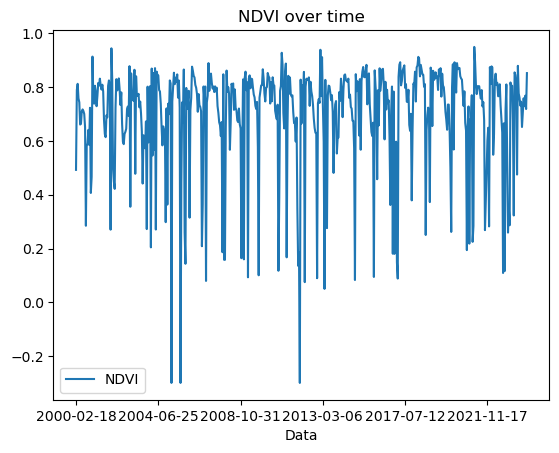

In [8]:
NDVI.plot(x="Data", y="NDVI", title="NDVI over time")

In [9]:
# class MLPDataset(torch.utils.data.Dataset):
#     def __init__(self, ndvi_df, prod_df):
#         self.ndvi_df = ndvi_df
#         self.prod_df = prod_df

#     def __len__(self):
#         return self.ndvi_df["Year"].nunique()

#     def __getitem__(self, idx):
#         years = self.ndvi_df["Year"].sort_values().unique()
#         if idx >= len(years):
#             raise IndexError("Index out of range")
#         year = years[idx]
#         ndvi = self.ndvi_df[self.ndvi_df["Year"] == year]["NDVI"].values
#         prod = self.prod_df[self.prod_df["Year"] == year][
#             "Productivity (kg/ha)"
#         ].values[0]
#         return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
#             prod, dtype=torch.float32
#         )


# dataset = MLPDataset(NDVI_last_20_per_year, PROD)
# dataset[0]

# train_size = len(dataset) - 8
# valid_size = 4
# test_size = 4
# train_dataset = torch.utils.data.Subset(dataset, range(train_size))
# valid_dateset = torch.utils.data.Subset(dataset, range(train_size, train_size + valid_size))
# test_dataset = torch.utils.data.Subset(dataset, range(train_size + valid_size, train_size + valid_size + test_size))

### 2.2. Preparar Datasets

#### 2.1.1. Normalização

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Normalizer dados NDVI

NDVI["Year_norm"] = NDVI["Year"].copy()

ndvi_scaler = StandardScaler().fit(NDVI[["NDVI"]].values)
NDVI["NDVI_norm"] = ndvi_scaler.transform(
    NDVI[["NDVI"]].values
)

scaler = MinMaxScaler(feature_range=(-1.0, 1.0))
NDVI["Year_norm"] = scaler.fit_transform(NDVI[["Year"]])

NDVI


,Data,NDVI,Year,N_Observations,Date_sin,Date_cos,Year_norm,NDVI_norm
0,2000-02-18,0.4925,2000,20,0.733885,0.679273,-1.0,-1.001186
1,2000-03-05,0.7898,2000,20,0.890617,0.454755,-1.0,0.472129
2,2000-03-21,0.8125,2000,20,0.980575,0.196143,-1.0,0.584623
3,2000-04-06,0.7585,2000,20,0.997018,-0.077175,-1.0,0.317017
4,2000-04-22,0.7437,2000,20,0.938710,-0.344707,-1.0,0.243674
...,...,...,...,...,...,...,...,...
544,2023-10-16,0.7588,2023,23,-0.970064,0.242850,1.0,0.318504
545,2023-11-01,0.7294,2023,23,-0.867456,0.497513,1.0,0.172808
546,2023-11-17,0.7683,2023,23,-0.699458,0.714673,1.0,0.365583
547,2023-12-03,0.7188,2023,23,-0.478734,0.877960,1.0,0.120278


In [11]:
# Normalizar produtividade
PROD["Year_norm"] = NDVI["Year"].copy()

prod_scaler = StandardScaler().fit(PROD[["Productivity (kg/ha)", "Year"]].values)
PROD[["Productivity_norm", "Year_norm"]] = prod_scaler.transform(
    PROD[["Productivity (kg/ha)", "Year"]].values
)
PROD

,Year,Production (kg),Area (ha),Productivity (kg/ha),Year_norm,Productivity_norm
26,2000,17424000,13200,1320.000000,-1.661325,0.425926
27,2001,17424000,13200,1320.000000,-1.516862,0.425926
28,2002,26325000,17550,1500.000000,-1.372399,1.171894
29,2003,13533000,17350,780.000000,-1.227936,-1.811979
30,2004,16560000,17250,960.000000,-1.083473,-1.066011
31,2005,16065000,17850,900.000000,-0.939010,-1.314667
32,2006,16065000,17850,900.000000,-0.794547,-1.314667
33,2007,16065000,17850,900.000000,-0.650084,-1.314667
34,2008,23958000,18150,1320.000000,-0.505621,0.425926
35,2009,20235000,17750,1140.000000,-0.361158,-0.320043


In [12]:
# class DatasetYearOfLast(torch.utils.data.Dataset):
#     """
#     DatasetYearOfLast - Dataset para previsão de produtividade

#     X: Sequências de tamanho <WINDOW_SIZE> de observações de NDVI consecutivas (normalizado -1 a +1)
#     y: Produtividade no Ano da última observação

#     Features:
#     - Sequências de NDVI (Já vem normalizado entre 0 e 1 da fonte)
#     - Sequências de dia do ano com codificação circular no formato de Tupla: (Seno, Cosseno)
#     - Sequência de ano da observação normalizado por z-score

#     Label:
#     - Produtividade (kg/ha) normalizada por z-score, relativa ao ano da última observação
#     """

#     def __init__(self, ndvi_df, prod_df, window_size=LSTM_WINDOW_SIZE):
#         self.ndvi_df = ndvi_df
#         self.prod_df = prod_df
#         self.window_size = window_size

#     def __len__(self):
#         return len(self.ndvi_df) - self.window_size

#     def __getitem__(self, idx):
#         ndvi = self.ndvi_df.iloc[idx : idx + self.window_size][
#             ["NDVI", "Date_sin", "Date_cos", "Year_norm"]
#         ].values

#         year = self.ndvi_df.iloc[idx + self.window_size - 1]["Year"]
#         prod = self.prod_df[self.prod_df["Year"] == year]["Productivity_norm"].values[0]

#         return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
#             prod, dtype=torch.float32
#         )


class DatasetYearOfLast(torch.utils.data.Dataset):
    def __init__(self, ndvi_df, prod_df, window_size=LSTM_WINDOW_SIZE):
        self.window_size = window_size
        self.prod_df = prod_df

        # Prepare windows grouped by year
        self.samples = []
        grouped = ndvi_df.groupby("Year")

        self.last_window_of_year = {}
        for year, group in grouped:
            group = group.sort_values("Data")
            for i in range(len(group) - window_size + 1):
                window = group.iloc[i : i + window_size]
                if len(window) == window_size:
                    self.samples.append((window, year))
                if i == len(group) - window_size:
                    self.last_window_of_year[year] = window
                    # print("ENtrou if:", self.samples[-1])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        window, year = self.samples[idx]
        ndvi = window[["NDVI", "Date_sin", "Date_cos", "Year_norm"]].values

        prod = self.prod_df[self.prod_df["Year"] == year]["Productivity_norm"].values[0]

        return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
            prod, dtype=torch.float32
        )

    def get_last_window_of_year(self, year) -> np.ndarray:
        """
        Retorna a última amostra do ano
        """
        if year not in self.last_window_of_year:
            raise ValueError(f"Year {year} not found in dataset")
        last = self.last_window_of_year[year]
        ndvi = last[["NDVI", "Date_sin", "Date_cos", "Year_norm"]].values
        return (
            ndvi,
            self.prod_df[self.prod_df["Year"] == year]["Productivity_norm"].values[0],
        )


years_train = [
    2000,
    2001,
    2002,
    2003,
    2006,
    2007,
    2008,
    2009,
    2012,
    2013,
    2014,
    2015,
    2018,
    2019,
    2020,
    2021,
]
years_validation = [2004, 2010, 2016, 2022]
years_test = [2005, 2011, 2017, 2023]


# Datasets better
mlp_train_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_train)], PROD, MLP_WINDOW_SIZE
)
mlp_validation_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_validation)], PROD, MLP_WINDOW_SIZE
)
mlp_test_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, MLP_WINDOW_SIZE
)

lstm_train_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_train)], PROD, LSTM_WINDOW_SIZE
)
lstm_validation_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_validation)], PROD, LSTM_WINDOW_SIZE
)
lstm_test_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, LSTM_WINDOW_SIZE
)

# Datasets sequential
# train_dataset_year_of_last = DatasetYearOfLast(
#     NDVI[NDVI["Year"] <= 2016], PROD, LSTM_WINDOW_SIZE
# )
# validation_dataset_year_of_last = DatasetYearOfLast(
#     NDVI[(NDVI["Year"] > 2016) & (NDVI["Year"] <= 2020)], PROD, LSTM_WINDOW_SIZE
# )
# test_dataset_year_of_last = DatasetYearOfLast(
#     NDVI[NDVI["Year"] > 2020], PROD, LSTM_WINDOW_SIZE
# )

print(mlp_validation_dataset_year_of_last[0][0].shape)
print(mlp_validation_dataset_year_of_last[0])
print(mlp_validation_dataset_year_of_last.get_last_window_of_year(2004))

torch.Size([10, 4])
(tensor([[ 0.6942,  0.0000,  1.0000, -0.6522],
        [ 0.8036,  0.2712,  0.9625, -0.6522],
        [ 0.2043,  0.5221,  0.8529, -0.6522],
        [ 0.8693,  0.7339,  0.6793, -0.6522],
        [ 0.5460,  0.8906,  0.4548, -0.6522],
        [ 0.8528,  0.9806,  0.1961, -0.6522],
        [ 0.5680,  0.9970, -0.0772, -0.6522],
        [ 0.8709,  0.9387, -0.3447, -0.6522],
        [ 0.2706,  0.8100, -0.5864, -0.6522],
        [ 0.8579,  0.6206, -0.7841, -0.6522]]), tensor(-1.0660))
(array([[ 0.7844    , -0.4161247 , -0.90930756, -0.65217391],
       [ 0.7386    , -0.64716067, -0.76235364, -0.65217391],
       [ 0.6518    , -0.82967701, -0.55824372, -0.65217391],
       [ 0.5836    , -0.94998992, -0.31228056, -0.65217391],
       [ 0.6542    , -0.99907917, -0.04290476, -0.65217391],
       [ 0.6266    , -0.97326437,  0.22968774, -0.65217391],
       [ 0.6419    , -0.87448096,  0.48505985, -0.65217391],
       [ 0.298     , -0.71013502,  0.70406552, -0.65217391],
       [ 0.

In [13]:
# Sanity check
print("Last window of 2017 in the DataFrame:")
print(
    NDVI[NDVI["Year"] == 2017][["NDVI", "Date_sin", "Date_cos", "Year_norm"]].tail(
        LSTM_WINDOW_SIZE
    )
)

print(
    f"\nProdutivity 2017: {PROD[PROD['Year'] == 2017]['Productivity (kg/ha)'].values[0]}"
)
print(
    f"Produtivity 2017 (normalized): {PROD[PROD['Year'] == 2017]['Productivity_norm'].values[0]}"
)

print(f"\nLast window of 2017 in the DatasetYearOfLast (values should match exactely):")
print(lstm_test_dataset_year_of_last.get_last_window_of_year(2017))

assert (
    lstm_test_dataset_year_of_last.get_last_window_of_year(2017)[0]
    == NDVI[NDVI["Year"] == 2017][["NDVI", "Date_sin", "Date_cos", "Year_norm"]]
    .tail(LSTM_WINDOW_SIZE)
    .values
).all(), "\n❌ Sanity check failed! Please check the DatasetYearOfLast class"
print("\n✅ Sanity check passed for LSTM! You can look values by yourself if you want to double check.")

Last window of 2017 in the DataFrame:
       NDVI  Date_sin  Date_cos  Year_norm
391  0.0882  0.735417  0.677615   0.478261
392  0.8388  0.891981  0.452072   0.478261
393  0.8836  0.981306  0.192452   0.478261
394  0.8929  0.996659 -0.081676   0.478261
395  0.8069  0.936881 -0.349647   0.478261
396  0.8232  0.806480 -0.591261   0.478261
397  0.8625  0.615285 -0.788305   0.478261
398  0.8716  0.377708 -0.925925   0.478261
399  0.8813  0.111659 -0.993747   0.478261
400  0.7974 -0.162807 -0.986658   0.478261
401  0.8113 -0.425000 -0.905193   0.478261
402  0.7458 -0.655156 -0.755493   0.478261
403  0.7455 -0.835925 -0.548843   0.478261
404  0.7905 -0.953681 -0.300820   0.478261
405  0.6598 -0.999546 -0.030120   0.478261
406  0.6377 -0.970064  0.242850   0.478261
407  0.7011 -0.867456  0.497513   0.478261
408  0.3790 -0.699458  0.714673   0.478261
409  0.6382 -0.478734  0.877960   0.478261
410  0.8135 -0.221922  0.975065   0.478261

Produtivity 2017: 1433.3878887070375
Produtivity 2017 (nor

In [14]:
class DatasetWeightedAverage(torch.utils.data.Dataset):
    """DatasetWeightedAverage - Dataset para previsão de produtividade

    X: Sequências de tamanho <WINDOW_SIZE> de observações de NDVI consecutivas (normalizado -1 a +1)
    y: Produtividade média ponderada entre a produtividade do ano da primeira observação e do ano da última observação
    - (normalizado por z-score)
    - A média é ponderada pela quantidade de observações do ano da primeira e do ano da última observação

    Features:
    - Sequências de NDVI (Já vem normalizado entre 0 e 1 da fonte)
    - Sequências de dia do ano com codificação circular no formato de Tupla: (Seno, Cosseno)
    - Sequência de ano da observação normalizado por z-score

    Label:
    - Produtividade (kg/ha) média ponderada entre o ano da primeira e do ano da última observação, normalizada por z-score
    """

    def __init__(self, ndvi_df, prod_df, window_size=LSTM_WINDOW_SIZE):
        self.ndvi_df = ndvi_df
        self.prod_df = prod_df
        self.window_size = window_size

    def __len__(self):
        return len(self.ndvi_df) - self.window_size

    def __getitem__(self, idx):
        ndvi = self.ndvi_df.iloc[idx : idx + self.window_size][
            ["NDVI", "Date_sin", "Date_cos", "Year_norm"]
        ].values

        year_first = self.ndvi_df.iloc[idx]["Year"]
        year_last = self.ndvi_df.iloc[idx + self.window_size]["Year"]

        prod_first = self.prod_df[self.prod_df["Year"] == year_first][
            "Productivity_norm"
        ].values[0]
        prod_last = self.prod_df[self.prod_df["Year"] == year_last][
            "Productivity_norm"
        ].values[0]

        n_obs_first = self.ndvi_df.iloc[idx : idx + self.window_size].loc[
            self.ndvi_df.iloc[idx : idx + self.window_size]["Year"] == year_first
        ].shape[0]
        n_obs_last = self.ndvi_df.iloc[idx : idx + self.window_size].loc[
            self.ndvi_df["Year"] == year_last
        ].shape[0]

        # Ponderação
        prod = (n_obs_first * prod_first + n_obs_last * prod_last) / (
            n_obs_first + n_obs_last
        )
        return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
            prod, dtype=torch.float32
        )
        
# Test Dataset
train_dataset_year_of_last = DatasetWeightedAverage(NDVI[NDVI["Year"] <= 2016], PROD, LSTM_WINDOW_SIZE)
validation_dataset_year_of_last = DatasetWeightedAverage(NDVI[(NDVI["Year"] > 2016) & (NDVI["Year"] <= 2020)], PROD, LSTM_WINDOW_SIZE)
test_dataset_weighted_average = DatasetWeightedAverage(NDVI[NDVI["Year"] > 2020], PROD, LSTM_WINDOW_SIZE)

validation_dataset_year_of_last[10]

(tensor([[ 0.8716,  0.3777, -0.9259,  0.4783],
         [ 0.8813,  0.1117, -0.9937,  0.4783],
         [ 0.7974, -0.1628, -0.9867,  0.4783],
         [ 0.8113, -0.4250, -0.9052,  0.4783],
         [ 0.7458, -0.6552, -0.7555,  0.4783],
         [ 0.7455, -0.8359, -0.5488,  0.4783],
         [ 0.7905, -0.9537, -0.3008,  0.4783],
         [ 0.6598, -0.9995, -0.0301,  0.4783],
         [ 0.6377, -0.9701,  0.2428,  0.4783],
         [ 0.7011, -0.8675,  0.4975,  0.4783],
         [ 0.3790, -0.6995,  0.7147,  0.4783],
         [ 0.6382, -0.4787,  0.8780,  0.4783],
         [ 0.8135, -0.2219,  0.9751,  0.4783],
         [ 0.8090,  0.0000,  1.0000,  0.5652],
         [ 0.8576,  0.2720,  0.9623,  0.5652],
         [ 0.7467,  0.5234,  0.8521,  0.5652],
         [ 0.8737,  0.7354,  0.6776,  0.5652],
         [ 0.8808,  0.8920,  0.4521,  0.5652],
         [ 0.9128,  0.9813,  0.1925,  0.5652],
         [ 0.9061,  0.9967, -0.0817,  0.5652]]),
 tensor(0.9055))

## 3. Model training

### 3.1. Multi-layer Perceptron

Essa rede é uma feedforward perceptron multi-layer comum (1 camada interna).

As entradas são os 20 últimos NDVIs do ano, a saída é a produtividade prevista (kg/ha).

In [15]:
class AmplifiedTanh(nn.Module):
    def __init__(self, amplification_factor=1.0):
        super().__init__()
        self.amplification_factor = amplification_factor

    def forward(self, x):
        return self.amplification_factor * torch.tanh(x)


mlp_network = nn.Sequential(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(MLP_WINDOW_SIZE * 4, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    AmplifiedTanh(amplification_factor=1.5),
)

def init_linear_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            nn.init.normal_(m.bias, mean=0.0, std=0.01)

mlp_network.apply(init_linear_weights)

# for name, param in mlp_network.named_parameters():
#     print(f"{name}: {param}")

# Step-by-step debug the MLP
# x = torch.randn(20, 4)
# print(f"Input shape: {x.shape}\n{x}\n")
# for i, layer in enumerate(mlp_network):
#     x = layer(x)
#     print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}\n{x}\n")

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=40, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=1, bias=True)
  (8): AmplifiedTanh()
)

In [16]:
mlp_network = mlp_network.to(device)
optimizer = optim.Adam(mlp_network.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

mlp_losses_validation = []
mlp_losses_train = []
best_loss = float("inf")
saved_epoch = 0

mlp_train_loader_year_of_last = torch.utils.data.DataLoader(
    mlp_train_dataset_year_of_last, batch_size=4, shuffle=True, drop_last=True
)
mlp_validation_loader_year_of_last = torch.utils.data.DataLoader(
    mlp_validation_dataset_year_of_last, batch_size=4, shuffle=False, drop_last=True
)

for i in trange(400):
    epoch_losses_train = []

    mlp_network.train()
    for ndvi, prod in mlp_train_loader_year_of_last:
        ndvi, prod = ndvi.to(device), prod.to(device)
        optimizer.zero_grad()
        pred = mlp_network(ndvi)
        loss = loss_fn(pred, prod.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_losses_train.append(loss.item())

    epoch_losses_validation = []
    mlp_network.eval()
    with torch.no_grad():
        for ndvi, prod in mlp_validation_loader_year_of_last:
            ndvi, prod = ndvi.to(device), prod.to(device)
            pred = mlp_network(ndvi)
            loss = loss_fn(pred, prod.unsqueeze(1))
            epoch_losses_validation.append(loss.item())

        if np.mean(epoch_losses_validation) < best_loss:
            best_loss = np.mean(epoch_losses_validation)
            saved_epoch = i + 1
            torch.save(mlp_network.state_dict(), "mlp.pth")

    mlp_losses_train.append(np.mean(epoch_losses_train))
    mlp_losses_validation.append(np.mean(epoch_losses_validation))
print(f"\n\nSaved MLP model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}")

100%|██████████| 400/400 [01:09<00:00,  5.76it/s]



Saved MLP model	epoch: 105	validation loss: 0.4781


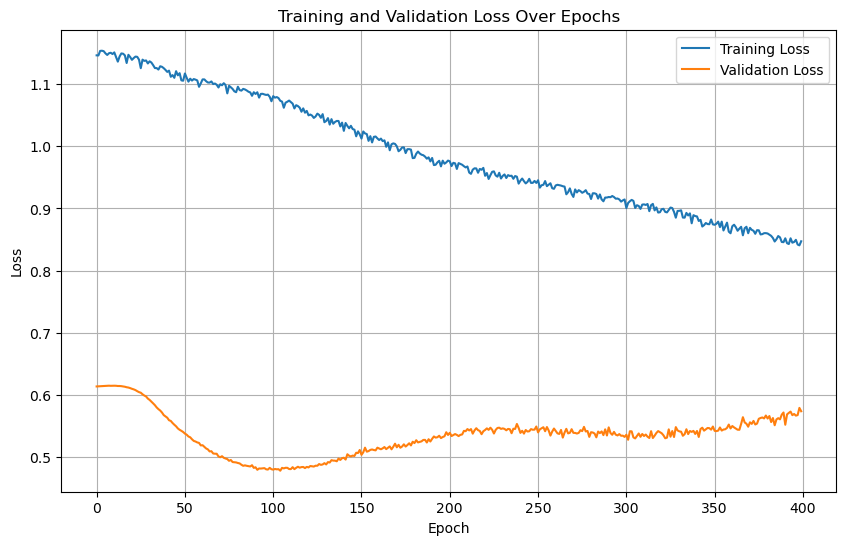

In [17]:
def plot_loss(train_losses, validation_losses):
    """
    Plots the training and validation losses over epochs.

    Args:
        train_losses (list): List of training loss values for each epoch.
        validation_losses (list): List of validation loss values for each epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(mlp_losses_train, mlp_losses_validation)

### 3.2. LSTM

In [18]:
import random

def cat_name_generator(gender: str): return random.choice({"macho": ["Thor", "Loki", "Zeus", "Hades", "Apolo", "Ares", "Hermes", "Poseidon", "Hércules", "Aquiles", "Ulisses", "Atlas", "Perseu", "Orfeu", "Eros", "Hefesto", "Dionísio", "Héracles", "Cronos", "Prometeu", "Teseu", "Orfeu", "Eolo"], "femea": ["Afrodite", "Artemis", "Deméter", "Hera", "Perséfone", "Atena", "Héstia", "Eris", "Selene", "Gaia", "Tétis", "Eurídice", "Calipso", "Medusa", "Circe"]}[gender])

cat_name_generator("femea")

'Eurídice'

In [19]:
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Define model with Linear layer
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=LSTM_DROPOUT
        )
        self.fc = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x, hidden_n=None, hidden_c=None):
        if hidden_n is None or hidden_c is None:
            out, _ = self.lstm(x)
            return self.fc(out[:, -1, :])  # Get output of last time step
        else:
            out, (hidden_n, hidden_c) = self.lstm(x, (hidden_n, hidden_c))
            out = self.fc(out[:, -1, :])  # Get output of last time step
            return out, (hidden_n, hidden_c)


lstm_train_loader_year_of_last = torch.utils.data.DataLoader(
    lstm_train_dataset_year_of_last,
    batch_size=LSTM_BATCH_SIZE,
    shuffle=False,
    drop_last=True,
)
lstm_validation_loader_year_of_last = torch.utils.data.DataLoader(
    lstm_validation_dataset_year_of_last,
    batch_size=LSTM_BATCH_SIZE,
    shuffle=False,
    drop_last=True,
)


lstm_model = LSTMRegressor(
    input_size=4, hidden_size=LSTM_HIDDEN_SIZE, num_layers=LSTM_NUM_LAYERS
).to(device)

# for name, param in lstm_model.named_parameters():
#     print(f"{name}: {param}")


def init_lstm_weights(m):
    if isinstance(m, nn.LSTM):
        nn.init.xavier_uniform_(m.weight_ih_l0)
        nn.init.xavier_uniform_(m.weight_hh_l0)


lstm_model.apply(init_lstm_weights)
lstm_model.apply(init_linear_weights)

optimizer = optim.Adam(lstm_model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

lstm_losses_train = []
lstm_losses_validation = []
best_loss = float("inf")
saved_epoch = 0


for i in trange(LSTM_EPOCHS):
    epoch_losses_train = []

    # h_n = torch.zeros(LSTM_NUM_LAYERS, LSTM_BATCH_SIZE, LSTM_HIDDEN_SIZE).to(
    #     device
    # )  # Hidden state
    # h_c = torch.zeros(LSTM_NUM_LAYERS, LSTM_BATCH_SIZE, LSTM_HIDDEN_SIZE).to(
    #     device
    # )  # Cell state

    lstm_model.train()
    for ndvi, prod in lstm_train_loader_year_of_last:
        ndvi, prod = ndvi.to(device), prod.to(device)
        optimizer.zero_grad()
        # pred, (h_n, h_c) = lstm_model(
        #     ndvi, h_n.detach(), h_c.detach()
        # )
        
        # Verificar se isto está certo
        # last_pred está correto?
        pred = lstm_model(ndvi)
        last_pred = pred[:, -1]
        loss = loss_fn(last_pred, prod)
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_model.parameters(), 1.0)
        optimizer.step()
        epoch_losses_train.append(loss.item())

    epoch_losses_validation = []
    lstm_model.eval()
    with torch.no_grad():
        for ndvi, prod in lstm_validation_loader_year_of_last:
            ndvi, prod = ndvi.to(device), prod.to(device)
            pred = lstm_model(ndvi)
            last_pred = pred[:, -1]  # Get the last prediction
            loss = loss_fn(last_pred, prod)
            epoch_losses_validation.append(loss.item())

        if np.mean(epoch_losses_validation) < best_loss:
            best_loss = np.mean(epoch_losses_validation)
            saved_epoch = i + 1
            torch.save(lstm_model.state_dict(), "lstm.pth")

    lstm_losses_train.append(np.mean(epoch_losses_train))
    lstm_losses_validation.append(np.mean(epoch_losses_validation))

print(f"\n\nSaved LSTM model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}")

100%|██████████| 200/200 [00:05<00:00, 35.59it/s]



Saved LSTM model	epoch: 91	validation loss: 0.3672


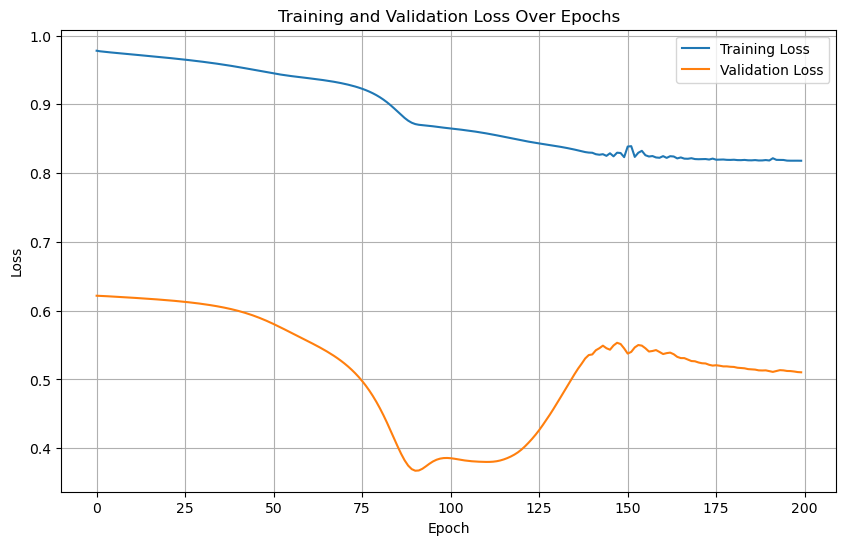

In [20]:
plot_loss(lstm_losses_train, lstm_losses_validation)

## 4. Avaliação do Modelo

In [21]:
mlp_test_loader_year_of_last = torch.utils.data.DataLoader(
    mlp_test_dataset_year_of_last, batch_size=4, shuffle=False, drop_last=True
)
lstm_test_loader_year_of_last = torch.utils.data.DataLoader(
    lstm_test_dataset_year_of_last, batch_size=4, shuffle=False, drop_last=True
)

# test MLP
# TODO:

test_losses_mlp = []
mlp_network.eval()
for ndvi, prod in mlp_test_loader_year_of_last:
    ndvi, prod = ndvi.to(device), prod.to(device)
    pred = mlp_network(ndvi)
    loss = loss_fn(pred, prod.unsqueeze(1))
    test_losses_mlp.append(loss.item())
print(f"MLP test loss: {np.mean(test_losses_mlp):.4f}")

# test LSTM
test_losses_lstm = []
lstm_model.eval()
for ndvi, prod in lstm_test_loader_year_of_last:
    ndvi, prod = ndvi.to(device), prod.to(device)
    pred = lstm_model(ndvi)
    last_pred = pred[:, -1]  # Get the last prediction
    loss = loss_fn(last_pred, prod)
    test_losses_lstm.append(loss.item())
print(f"LSTM test loss: {np.mean(test_losses_lstm):.4f}")

MLP test loss: 0.4808
LSTM test loss: 0.8723


LSTM Predictions for all test dataset:
[[-0.29942906]
 [-0.30098447]
 [-0.300228  ]
 [-0.29093766]
 [-0.29947075]
 [-0.30209878]
 [-0.30010092]
 [-0.2986393 ]
 [ 0.90234137]
 [ 0.9010211 ]
 [ 0.90028685]
 [ 0.8986299 ]
 [ 0.9097749 ]
 [ 0.90896237]
 [ 0.9071569 ]
 [ 0.90529996]]

Real Production (normalized) for all test dataset:
[-1.3146667  -1.3146667  -1.3146667  -1.3146667   0.9232376   0.9232376
  0.9232376   0.9232376   0.8958352   0.8958352   0.8958352   0.8958352
 -0.07138658 -0.07138658 -0.07138658 -0.07138658]


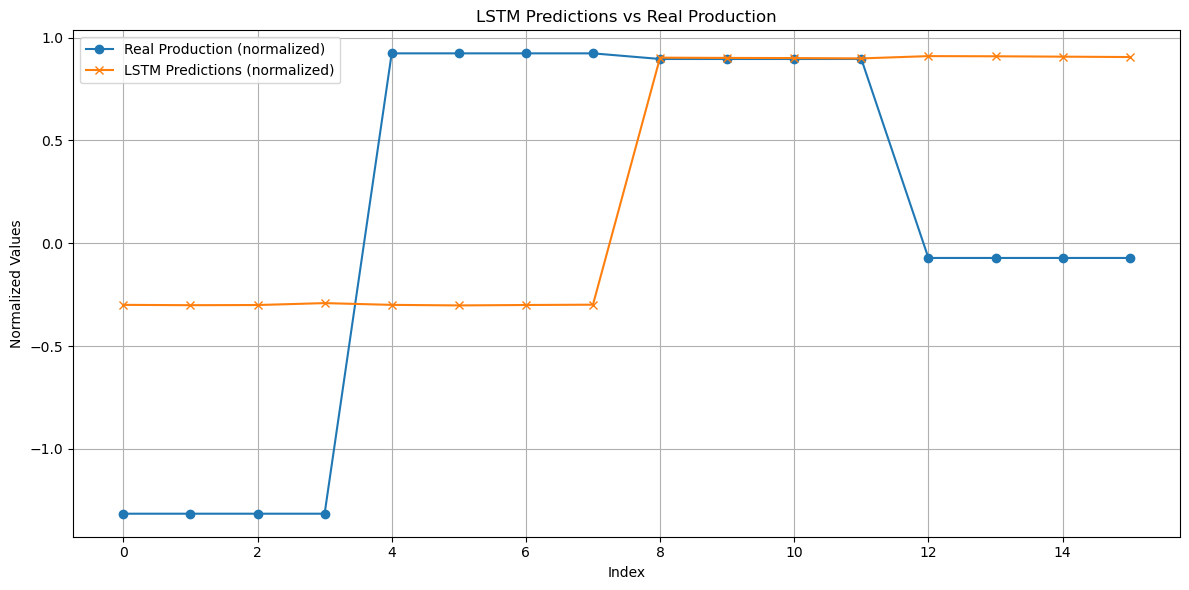

In [22]:
lstm_model.eval()
all_preds = []
real_prods = []

with torch.no_grad():
    for ndvi, prod in lstm_test_loader_year_of_last:
        ndvi, prod = ndvi.to(device), prod.to(device)
        pred = lstm_model(ndvi)
        all_preds.append(pred.cpu().numpy())
        real_prods.append(prod.cpu().numpy())

# Flatten the predictions and real productions
all_preds = np.concatenate(all_preds, axis=0)
real_prods = np.concatenate(real_prods, axis=0)

# Print predictions and real productions
print("LSTM Predictions for all test dataset:")
print(all_preds)
print("\nReal Production (normalized) for all test dataset:")
print(real_prods)

plt.figure(figsize=(12, 6))
plt.plot(real_prods, label="Real Production (normalized)", marker='o')
plt.plot(all_preds, label="LSTM Predictions (normalized)", marker='x')
plt.xlabel("Index")
plt.ylabel("Normalized Values")
plt.title("LSTM Predictions vs Real Production")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


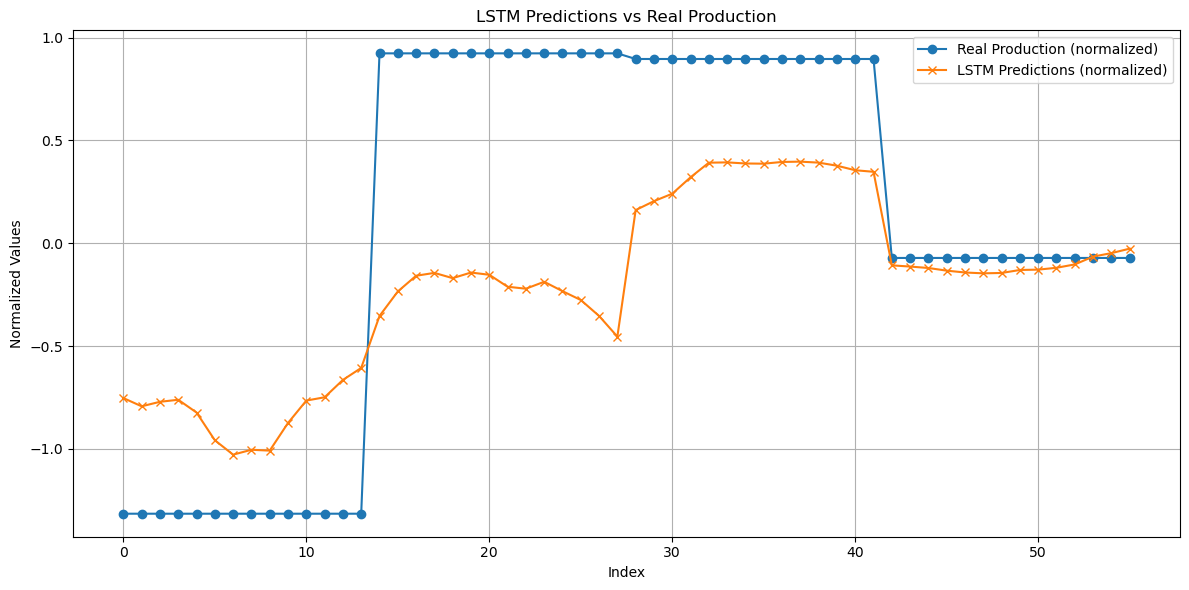

In [23]:
mlp_network.eval()
all_preds = []
real_prods = []

with torch.no_grad():
    for ndvi, prod in mlp_test_loader_year_of_last:
        ndvi, prod = ndvi.to(device), prod.to(device)
        pred = mlp_network(ndvi)
        all_preds.append(pred.cpu().numpy())
        real_prods.append(prod.cpu().numpy())

# Flatten the predictions and real productions
all_preds = np.concatenate(all_preds, axis=0).flatten()
real_prods = np.concatenate(real_prods, axis=0).flatten()

# Print predictions and real productions
# print("LSTM Predictions for all test dataset:")
# print(all_preds)
# print("\nReal Production (normalized) for all test dataset:")
# print(real_prods)

plt.figure(figsize=(12, 6))
plt.plot(real_prods, label="Real Production (normalized)", marker='o')
plt.plot(all_preds, label="LSTM Predictions (normalized)", marker='x')
plt.xlabel("Index")
plt.ylabel("Normalized Values")
plt.title("LSTM Predictions vs Real Production")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
print("MLP test loss:", np.mean(test_losses_mlp))
for y_test in years_test:
    ndvi, prod = mlp_test_dataset_year_of_last.get_last_window_of_year(y_test)
    ndvi = torch.tensor(ndvi, dtype=torch.float32).unsqueeze(0).to(device)
    pred = mlp_network(ndvi)
    last_pred = pred[:, -1].cpu().detach().numpy()[0]
    test_losses_mlp.append(last_pred)
    print(f"\n[MLP] Predicted (normalized) productivity for {y_test}: {last_pred:.4f}")
    print(f"[MLP] Real productivity (normalized) for {y_test}: {prod:.4f}")

print("\n\nLSTM test loss:", np.mean(test_losses_lstm))
for y_test in years_test:
    ndvi, prod = lstm_test_dataset_year_of_last.get_last_window_of_year(y_test)
    ndvi = torch.tensor(ndvi, dtype=torch.float32).unsqueeze(0).to(device)
    pred = lstm_model(ndvi)
    last_pred = pred[:, -1].cpu().detach().numpy()[0]
    print(f"\n[LSTM] Predicted productivity (normalized) for {y_test}: {last_pred:.4f}")
    print(f"[LSTM] Real productivity (normalized) for {y_test}: {prod:.4f}")

MLP test loss: 0.48081217383982483

[MLP] Predicted (normalized) productivity for 2005: -0.6060
[MLP] Real productivity (normalized) for 2005: -1.3147

[MLP] Predicted (normalized) productivity for 2011: -0.4538
[MLP] Real productivity (normalized) for 2011: 0.9232

[MLP] Predicted (normalized) productivity for 2017: 0.3475
[MLP] Real productivity (normalized) for 2017: 0.8958

[MLP] Predicted (normalized) productivity for 2023: -0.0262
[MLP] Real productivity (normalized) for 2023: -0.0714


LSTM test loss: 0.8722934308893855

[LSTM] Predicted productivity (normalized) for 2005: -0.2909
[LSTM] Real productivity (normalized) for 2005: -1.3147

[LSTM] Predicted productivity (normalized) for 2011: -0.2986
[LSTM] Real productivity (normalized) for 2011: 0.9232

[LSTM] Predicted productivity (normalized) for 2017: 0.8986
[LSTM] Real productivity (normalized) for 2017: 0.8958

[LSTM] Predicted productivity (normalized) for 2023: 0.9053
[LSTM] Real productivity (normalized) for 2023: -0.0714